In [ ]:

# === Setup ===
import os, sys, glob, math, zipfile
from pathlib import Path
import numpy as np
import cv2
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (6,4)
plt.rcParams['axes.grid'] = True

# --- Colab: mount Google Drive ---
try:
    from google.colab import drive  # type: ignore
    drive.mount('/content/drive')
    IN_COLAB = True
except Exception:
    print("Not running in Colab (drive mount skipped).")
    IN_COLAB = False

# Your Drive folder (adjust if needed)
DATA_DIR = Path("/content/drive/MyDrive/a1images/a1images")

# Helpers
def imread_any(path):
    p = str(path)
    img = cv2.imread(p, cv2.IMREAD_UNCHANGED)
    if img is None:
        raise FileNotFoundError(f"Could not open image at: {p}")
    if len(img.shape) == 3 and img.shape[2] == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def show(title, img, cmap=None):
    import matplotlib.pyplot as plt
    plt.figure()
    plt.title(title)
    if img.ndim == 2:
        plt.imshow(img, cmap=cmap or "gray")
    else:
        plt.imshow(img)
    plt.axis("off")
    plt.show()

def clip8(x):
    return np.clip(np.rint(x), 0, 255).astype(np.uint8)

def ensure_gray(img):
    if img.ndim == 2:
        return img
    elif img.ndim == 3 and img.shape[2] == 3:
        return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
        raise ValueError("Unsupported image shape for grayscale conversion.")


Mounted at /content/drive



## Q1 — Intensity transform on **emma.jpg**


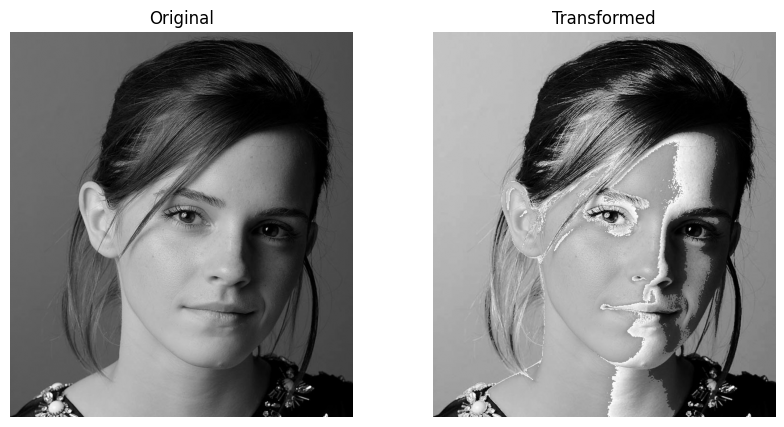

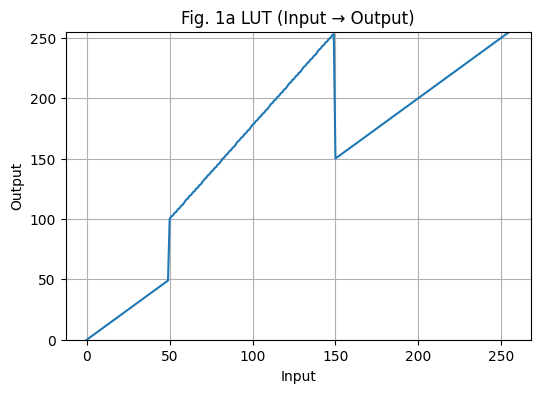

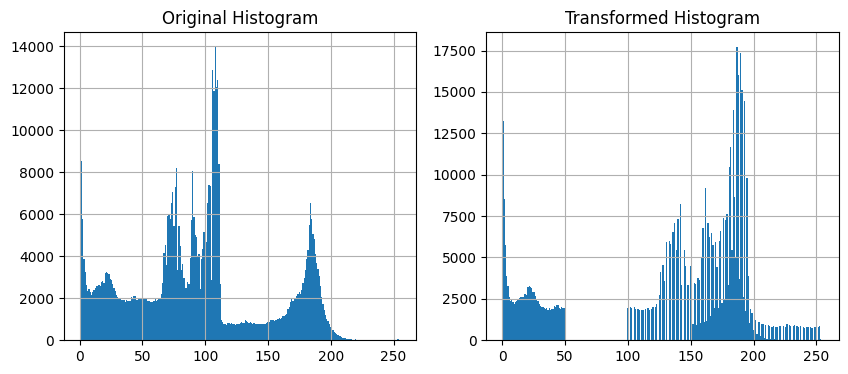

Transformed image saved at: /content/drive/MyDrive/a1images/a1images/emma_transformed_fig1a.png


In [ ]:
from pathlib import Path
import cv2
import numpy as np
import matplotlib.pyplot as plt

# --- Path to your Drive image ---
DATA_DIR = Path("/content/drive/MyDrive/a1images/a1images")
img_path = DATA_DIR / "emma.jpg"

# --- Load image and convert to grayscale ---
img = cv2.imread(str(img_path))
if img is None:
    raise FileNotFoundError(f"Could not open {img_path}")
g = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# --- Build LUT for Fig. 1a ---
lut = np.zeros(256, dtype=np.uint8)

# 0..49 -> y = x
lut[0:50] = np.arange(0, 50, dtype=np.uint8)

# jump at x=50 → output = 100
lut[50] = 100

# 51..149 → line from (50,100) → (150,255), slope ≈ 1.55
x = np.arange(51, 150)
lut[51:150] = np.clip(np.rint(100 + 1.55 * (x - 50)), 0, 255).astype(np.uint8)

# drop at x=150 → output = 150
lut[150] = 150

# 151..255 → y = x
lut[151:256] = np.arange(151, 256, dtype=np.uint8)

# --- Apply LUT ---
out = cv2.LUT(g, lut)

# --- Save transformed image back to Drive ---
out_path = DATA_DIR / "emma_transformed_fig1a.png"
cv2.imwrite(str(out_path), out)

# --- Visualize ---
plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.title("Original");    plt.imshow(g, cmap="gray");   plt.axis("off")
plt.subplot(1,2,2); plt.title("Transformed"); plt.imshow(out, cmap="gray"); plt.axis("off")
plt.show()

plt.figure(); plt.title("Fig. 1a LUT (Input → Output)")
plt.plot(lut); plt.xlabel("Input"); plt.ylabel("Output"); plt.ylim(0,255); plt.grid(True); plt.show()

plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.title("Original Histogram");   plt.hist(g.ravel(), bins=256, range=(0,255))
plt.subplot(1,2,2); plt.title("Transformed Histogram"); plt.hist(out.ravel(), bins=256, range=(0,255))
plt.show()

print("Transformed image saved at:", out_path)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).




## Q2 — Accentuate white/gray matter on **brain_proton_density_slice.png**



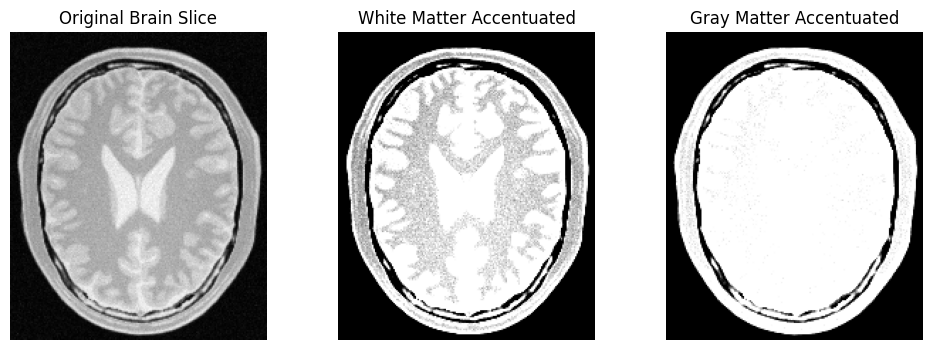

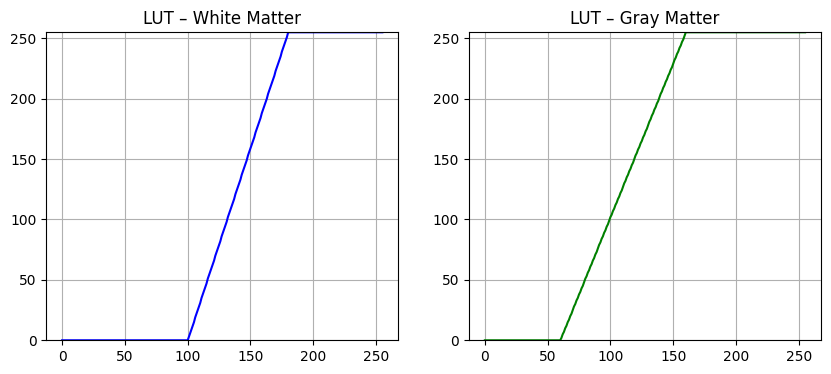

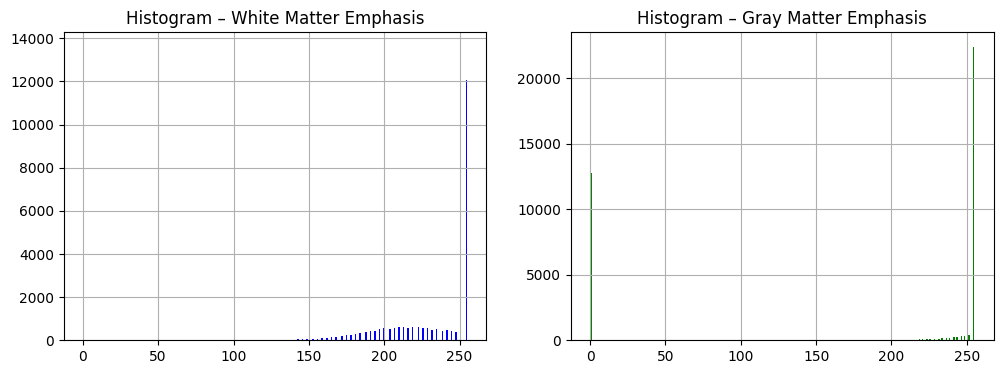

Explanation:
- Windowing maps a specific input intensity range to the full [0,255] output range.
- By choosing center and width, we can emphasize tissue contrasts:
   * White matter: higher intensity range → brighter structures emphasized.
   * Gray matter: mid intensity range → gray tissues emphasized.
- Pixels outside the chosen window are clipped to black (0) or white (255).


In [ ]:
# Q2 – Accentuating White and Gray Matter with Intensity Transformations
import cv2, numpy as np, matplotlib.pyplot as plt
from pathlib import Path

# ----------------------------
# Load the brain proton density image
# ----------------------------
DATA_DIR = Path("/content/drive/MyDrive/a1images/a1images")
q2_path  = DATA_DIR / "brain_proton_density_slice.png"

img_q2 = cv2.imread(str(q2_path), cv2.IMREAD_GRAYSCALE)
if img_q2 is None:
    raise FileNotFoundError(f"Could not open {q2_path}")

# ----------------------------
# Define window LUT builder
# ----------------------------
def window_lut(center, width):
    x = np.arange(256, dtype=np.float32)
    low, high = center - width/2.0, center + width/2.0
    y = (x - low) / (high - low)
    y = np.clip(y, 0, 1) * 255
    return y.astype(np.uint8)

# ----------------------------
# Define windows for WM and GM
# (you can fine-tune center/width by inspecting histograms)
# ----------------------------
lut_white = window_lut(center=140, width=80)   # White matter (brighter)
lut_gray  = window_lut(center=110, width=100)  # Gray matter (mid-range)

# Apply LUTs
img_white = cv2.LUT(img_q2, lut_white)
img_gray  = cv2.LUT(img_q2, lut_gray)

# ----------------------------
# Show images
# ----------------------------
plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.title("Original Brain Slice"); plt.imshow(img_q2, cmap="gray"); plt.axis("off")
plt.subplot(1,3,2); plt.title("White Matter Accentuated"); plt.imshow(img_white, cmap="gray"); plt.axis("off")
plt.subplot(1,3,3); plt.title("Gray Matter Accentuated"); plt.imshow(img_gray, cmap="gray"); plt.axis("off")
plt.show()

# ----------------------------
# Show LUTs
# ----------------------------
plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.title("LUT – White Matter"); plt.plot(lut_white, color="blue"); plt.ylim(0,255); plt.grid(True)
plt.subplot(1,2,2); plt.title("LUT – Gray Matter");  plt.plot(lut_gray, color="green"); plt.ylim(0,255); plt.grid(True)
plt.show()

# ----------------------------
# Histograms
# ----------------------------
plt.figure(figsize=(12,4))
plt.subplot(1,2,1); plt.title("Histogram – White Matter Emphasis"); plt.hist(img_white.ravel(), bins=256, range=(0,255), color="blue")
plt.subplot(1,2,2); plt.title("Histogram – Gray Matter Emphasis");  plt.hist(img_gray.ravel(),  bins=256, range=(0,255), color="green")
plt.show()

# ----------------------------
# Explanation
# ----------------------------
print("Explanation:")
print("- Windowing maps a specific input intensity range to the full [0,255] output range.")
print("- By choosing center and width, we can emphasize tissue contrasts:")
print("   * White matter: higher intensity range → brighter structures emphasized.")
print("   * Gray matter: mid intensity range → gray tissues emphasized.")
print("- Pixels outside the chosen window are clipped to black (0) or white (255).")


## Q3 — Gamma correction on  **highlights_and_shadows.jpg**


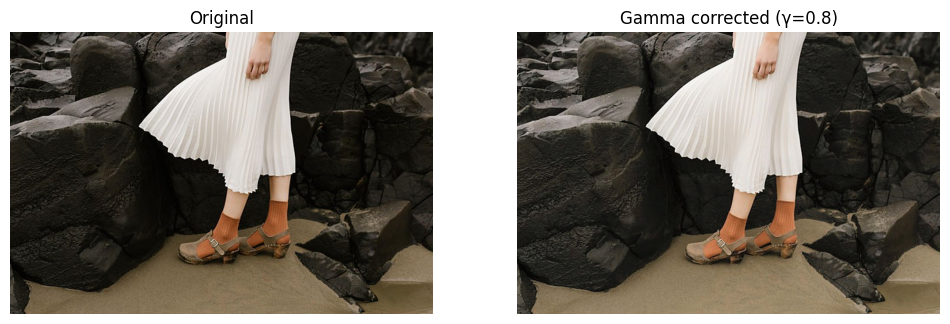

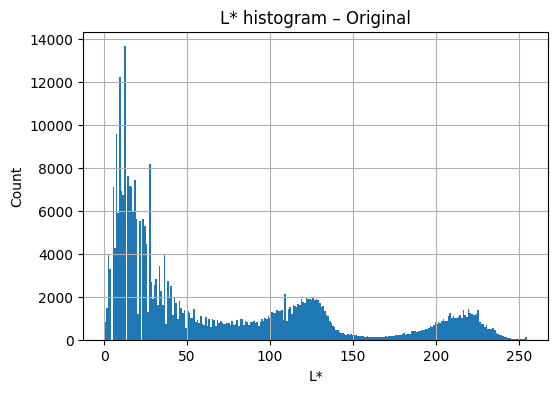

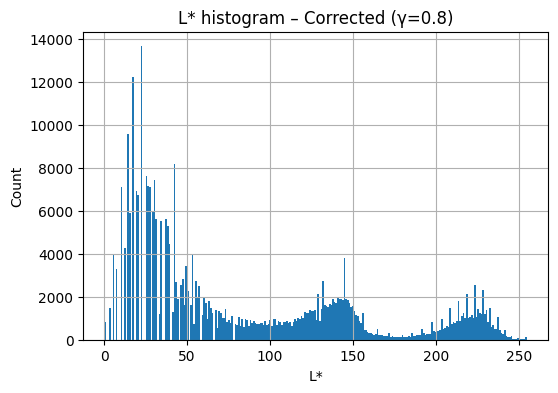

Used gamma γ = 0.8 on the L* channel only. Gamma < 1 brightens midtones; gamma > 1 darkens them. Chromatic channels a* and b* were preserved.


In [ ]:
# Q3 — Gamma correction on the L* plane (L*a*b*)
from pathlib import Path
import cv2, numpy as np, matplotlib.pyplot as plt

# ---- Paths ----
DATA_DIR = Path("/content/drive/MyDrive/a1images/a1images")
q3_path  = DATA_DIR / "highlights_and_shadows.jpg"   # <- your image for Q3

# ---- Load image (BGR) ----
img_bgr = cv2.imread(str(q3_path), cv2.IMREAD_COLOR)
if img_bgr is None:
    raise FileNotFoundError(f"Could not open {q3_path}")

# ---- Convert to Lab and split channels ----
lab = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2LAB)
L, a, b = cv2.split(lab)                # OpenCV stores L* scaled to [0,255]

# ---- Choose gamma (γ) ----
gamma = 0.8   # <— state this value; γ<1 brightens midtones, γ>1 darkens

# ---- Apply gamma to L* only ----
Lf = L.astype(np.float32) / 255.0       # normalize to [0,1]
Lg = np.power(Lf, gamma)                # gamma correction
L_corr = np.clip(Lg * 255.0, 0, 255).astype(np.uint8)

# ---- Merge back and convert to BGR/RGB for display ----
lab_corr = cv2.merge([L_corr, a, b])
img_corr_bgr = cv2.cvtColor(lab_corr, cv2.COLOR_LAB2BGR)
img_rgb      = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
img_corr_rgb = cv2.cvtColor(img_corr_bgr, cv2.COLOR_BGR2RGB)

# ---- Show original vs corrected ----
plt.figure(figsize=(12,5))
plt.subplot(1,2,1); plt.title("Original");            plt.imshow(img_rgb);      plt.axis("off")
plt.subplot(1,2,2); plt.title(f"Gamma corrected (γ={gamma})"); plt.imshow(img_corr_rgb); plt.axis("off")
plt.show()

# ---- Histograms of L* (as requested) ----
plt.figure(); plt.title("L* histogram – Original")
plt.hist(L.ravel(), bins=256, range=(0,255)); plt.xlabel("L*"); plt.ylabel("Count"); plt.show()

plt.figure(); plt.title(f"L* histogram – Corrected (γ={gamma})")
plt.hist(L_corr.ravel(), bins=256, range=(0,255)); plt.xlabel("L*"); plt.ylabel("Count"); plt.show()

print(f"Used gamma γ = {gamma} on the L* channel only. "
      "Gamma < 1 brightens midtones; gamma > 1 darkens them. "
      "Chromatic channels a* and b* were preserved.")



## Q4 — Vibrance on **spider.png** (S channel in HSV)


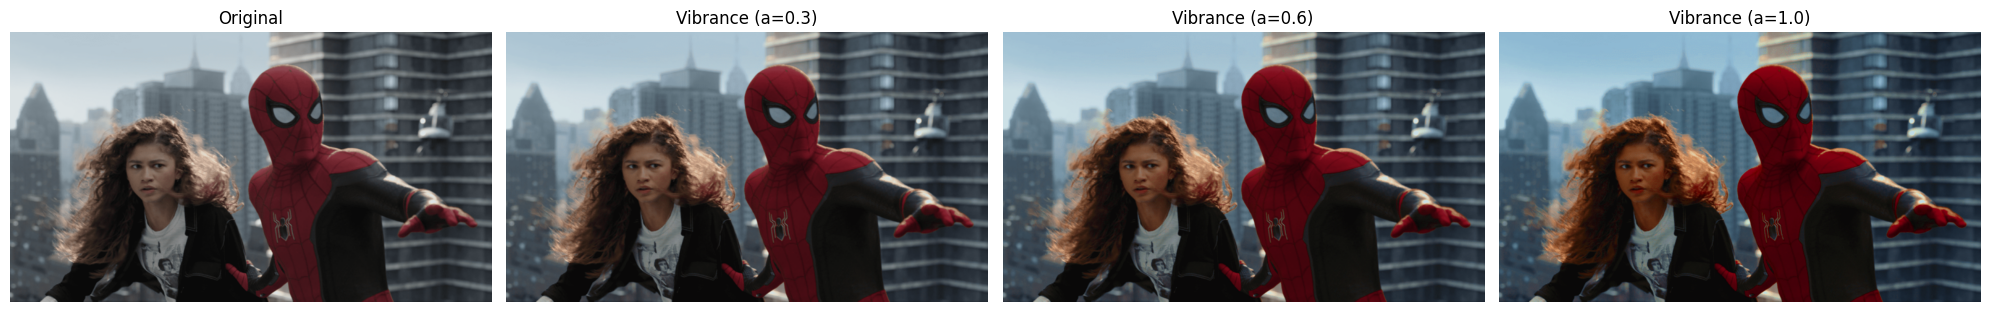

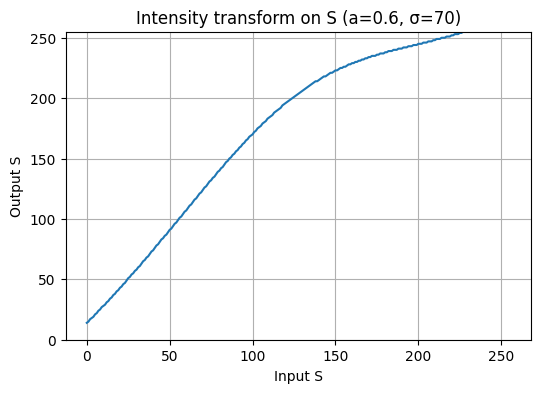

Saved: /content/drive/MyDrive/a1images/a1images/spider_vibrance_a0.60.png
Explanation:
- The transformation adds a Gaussian 'bump' centered at S=128 to the saturation channel.
- Parameter a∈[0,1] scales the bump; σ=70 controls its width.
- Mid-saturated pixels receive the largest boost, while very low/high S changes little.
- Reported a (visually chosen): 0.6


In [ ]:
# Q4 — Vibrance enhancement using the specified intensity transform on Saturation
from pathlib import Path
import numpy as np, cv2, matplotlib.pyplot as plt

# --- paths ---
DATA_DIR = Path("/content/drive/MyDrive/a1images/a1images")
q4_path  = DATA_DIR / "spider.png"   # <- your image for Q4

# --- load (RGB for plotting; HSV for processing) ---
img_bgr = cv2.imread(str(q4_path), cv2.IMREAD_COLOR)
if img_bgr is None:
    raise FileNotFoundError(f"Could not open {q4_path}")
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

# --- vibrance transform: Gaussian bump around mid-saturation (x≈128) ---
def vibrance_curve_gaussian(a=0.6, sigma=70.0):
    """
    Return 256-entry LUT implementing:
        f(x) = min( x + a*128*exp(-(x-128)^2/(2*sigma^2)), 255 )
    """
    x = np.arange(256, dtype=np.float32)
    bump = a * 128.0 * np.exp(-((x - 128.0) ** 2) / (2.0 * (sigma ** 2)))
    y = np.minimum(x + bump, 255.0)
    return y.astype(np.uint8)

def apply_vibrance_on_s(rgb, a=0.6, sigma=70.0):
    hsv = cv2.cvtColor(rgb, cv2.COLOR_RGB2HSV)
    H, S, V = cv2.split(hsv)           # S in [0,255]
    lut = vibrance_curve_gaussian(a=a, sigma=sigma)
    S2 = cv2.LUT(S, lut)               # transformed saturation
    out_rgb = cv2.cvtColor(cv2.merge([H, S2, V]), cv2.COLOR_HSV2RGB)
    return out_rgb, lut, S, S2

# --- try a few 'a' values and show them next to the original ---
a_candidates = [0.3, 0.6, 1.0]   # per spec, a ∈ [0,1]
ncols = 1 + len(a_candidates)

plt.figure(figsize=(5*ncols, 6))
plt.subplot(1, ncols, 1)
plt.imshow(img_rgb)
plt.title("Original")
plt.axis("off")

results = []
for idx, a in enumerate(a_candidates, start=2):
    out_rgb, lut, S0, S1 = apply_vibrance_on_s(img_rgb, a=a, sigma=70.0)
    results.append((a, out_rgb, lut))
    plt.subplot(1, ncols, idx)
    plt.imshow(out_rgb)
    plt.title(f"Vibrance (a={a})")
    plt.axis("off")

plt.tight_layout()
plt.show()

# --- choose a visually pleasing 'a' (you can change this after viewing) ---
best_a = 0.6   # <- REPORT this value in your write-up
best_img, best_lut, *_ = apply_vibrance_on_s(img_rgb, a=best_a, sigma=70.0)

# --- show intensity transformation (the LUT used on S) ---
plt.figure()
plt.title(f"Intensity transform on S (a={best_a}, σ=70)")
plt.plot(best_lut)
plt.xlabel("Input S")
plt.ylabel("Output S")
plt.ylim(0,255)
plt.grid(True)
plt.show()

# --- save result (optional) ---
out_path = DATA_DIR / f"spider_vibrance_a{best_a:.2f}.png"
cv2.imwrite(str(out_path), cv2.cvtColor(best_img, cv2.COLOR_RGB2BGR))
print("Saved:", out_path)

print(
    "Explanation:\n"
    "- The transformation adds a Gaussian 'bump' centered at S=128 to the saturation channel.\n"
    "- Parameter a∈[0,1] scales the bump; σ=70 controls its width.\n"
    "- Mid-saturated pixels receive the largest boost, while very low/high S changes little.\n"
    f"- Reported a (visually chosen): {best_a}"
)




## Q5 — Foreground-only histogram equalization on **jeniffer.jpg** (HSV workflow)


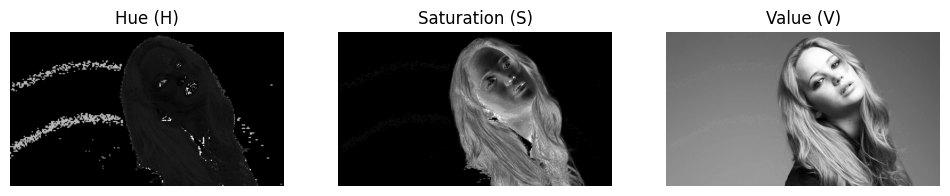

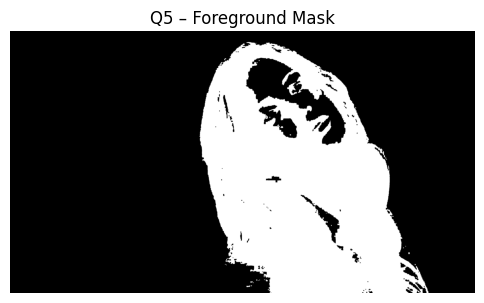

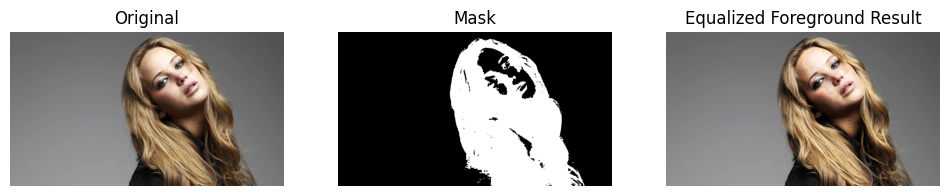

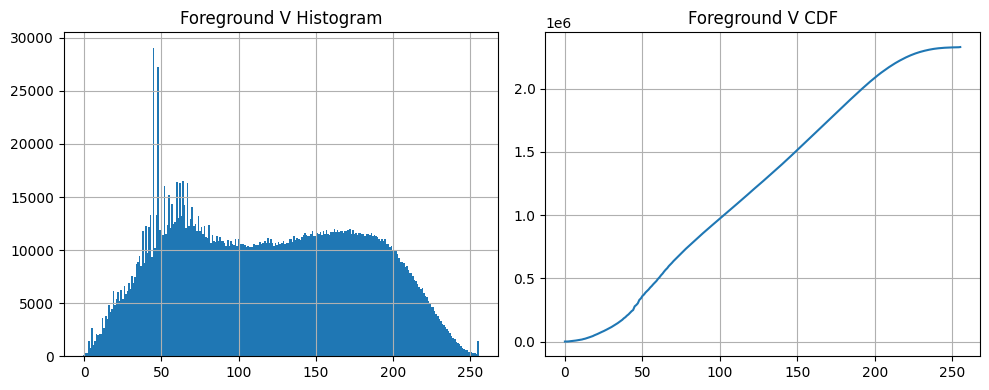

In [ ]:
# Q5 — Histogram equalization ONLY on the foreground
from pathlib import Path
import cv2, numpy as np, matplotlib.pyplot as plt

# ----------------------------
# (a) Open and split into HSV; show planes in grayscale
# ----------------------------
DATA_DIR = Path("/content/drive/MyDrive/a1images/a1images")
q5_path  = DATA_DIR / "jeniffer.jpg"       # <-- use the given image

img_bgr = cv2.imread(str(q5_path), cv2.IMREAD_COLOR)
if img_bgr is None:
    raise FileNotFoundError(f"Could not open {q5_path}")

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
hsv     = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)
H, S, V = cv2.split(hsv)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.title("Hue (H)");        plt.imshow(H, cmap="gray"); plt.axis("off")
plt.subplot(1,3,2); plt.title("Saturation (S)"); plt.imshow(S, cmap="gray"); plt.axis("off")
plt.subplot(1,3,3); plt.title("Value (V)");      plt.imshow(V, cmap="gray"); plt.axis("off")
plt.show()

# ----------------------------
# (b) Build a foreground mask
#     Gray studio background has LOW saturation → threshold on S
# ----------------------------
S_blur = cv2.GaussianBlur(S, (5,5), 0)
_, mask0 = cv2.threshold(S_blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Clean mask (remove small noise / fill small gaps)
kernel = np.ones((5,5), np.uint8)
mask = cv2.morphologyEx(mask0, cv2.MORPH_OPEN, kernel, iterations=1)
mask = cv2.morphologyEx(mask,  cv2.MORPH_CLOSE, kernel, iterations=1)

plt.figure(); plt.title("Q5 – Foreground Mask"); plt.imshow(mask, cmap="gray"); plt.axis("off"); plt.show()

# ----------------------------
# (c) Foreground only & histogram on V
# ----------------------------
fg_V = cv2.bitwise_and(V, V, mask=mask)

# (d) CDF of foreground histogram
hist = cv2.calcHist([fg_V], [0], mask, [256], [0,256]).ravel()
cdf  = np.cumsum(hist)

# ----------------------------
# (e) Equalize ONLY the foreground using the slide formula
#     T(i) = round( (CDF(i) - CDF_min) / (N - CDF_min) * 255 )
# ----------------------------
cdf_min = cdf[hist > 0][0] if np.any(hist > 0) else 0.0
N       = cdf[-1] if cdf[-1] > 0 else 1.0

eq_lut = np.round((cdf - cdf_min) / (N - cdf_min) * 255.0)
eq_lut = np.clip(eq_lut, 0, 255).astype(np.uint8)   # 256-length LUT

V_eq = V.copy()
V_eq[mask > 0] = eq_lut[V[mask > 0]]               # map foreground only

# (f) Keep background untouched and recombine HSV → RGB
res_rgb = cv2.cvtColor(cv2.merge([H, S, V_eq]), cv2.COLOR_HSV2RGB)

# ----------------------------
# Display required outputs
# ----------------------------
plt.figure(figsize=(12,5))
plt.subplot(1,3,1); plt.title("Original"); plt.imshow(img_rgb);  plt.axis("off")
plt.subplot(1,3,2); plt.title("Mask");     plt.imshow(mask, cmap="gray"); plt.axis("off")
plt.subplot(1,3,3); plt.title("Equalized Foreground Result"); plt.imshow(res_rgb); plt.axis("off")
plt.show()

# (Optional) Show foreground histogram & CDF for your report
plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.title("Foreground V Histogram"); plt.bar(np.arange(256), hist, width=1.0)
plt.subplot(1,2,2); plt.title("Foreground V CDF");       plt.plot(cdf)
plt.tight_layout(); plt.show()



## Q6 — Sobel filtering on **einstein.png** (three ways)


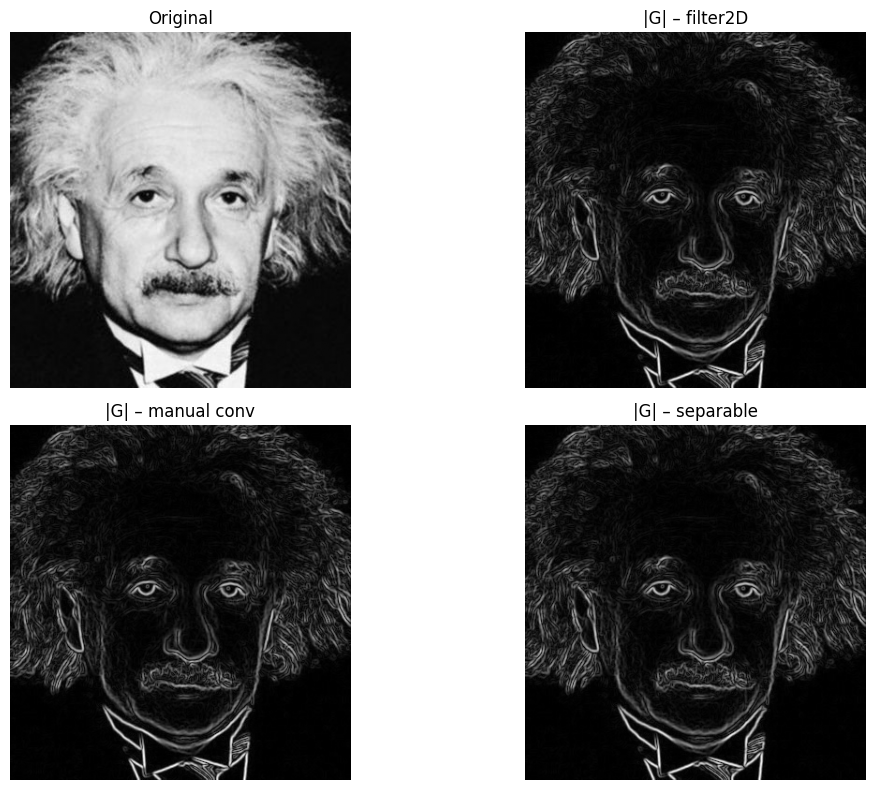

MSE (filter2D vs manual):     0.000000
MSE (filter2D vs separable):  0.000000
MSE (manual vs separable):    0.000000

Notes:
- (a) uses the standard 3×3 Sobel kernels with cv2.filter2D.
- (b) implements convolution explicitly (with replicate padding) and matches (a).
- (c) uses the separable property  Kx = [1,2,1]^T * [1,0,-1],  Ky = [1,0,-1]^T * [1,2,1],
  applied via cv2.sepFilter2D, which is typically faster and numerically equivalent.


In [ ]:
# Q6 — Sobel filtering (a) filter2D, (b) manual conv, (c) separable property
from pathlib import Path
import cv2
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------
# Load image (grayscale)
# ----------------------------
DATA_DIR = Path("/content/drive/MyDrive/a1images/a1images")  # adjust if needed
q6_path  = DATA_DIR / "einstein.png"

g = cv2.imread(str(q6_path), cv2.IMREAD_GRAYSCALE)
if g is None:
    raise FileNotFoundError(f"Could not open {q6_path}")
gf = g.astype(np.float32)

def norm8(x):
    x = np.asarray(x, np.float32)
    m = x.min()
    M = x.max()
    if M - m < 1e-6:
        return np.zeros_like(x, dtype=np.uint8)
    return np.clip((x - m) * 255.0 / (M - m), 0, 255).astype(np.uint8)

# 3×3 Sobel kernels
Kx = np.array([[1, 0, -1],
               [2, 0, -2],
               [1, 0, -1]], dtype=np.float32)
Ky = Kx.T

# ----------------------------
# (a) Sobel via filter2D
# ----------------------------
Gx_a = cv2.filter2D(gf, ddepth=cv2.CV_32F, kernel=Kx, borderType=cv2.BORDER_REPLICATE)
Gy_a = cv2.filter2D(gf, ddepth=cv2.CV_32F, kernel=Ky, borderType=cv2.BORDER_REPLICATE)
Mag_a = np.hypot(Gx_a, Gy_a)

# ----------------------------
# (b) Manual 2-D convolution + gradient magnitude
# ----------------------------
def conv2_manual(img_f32, kernel):
    kh, kw = kernel.shape
    py, px = kh // 2, kw // 2
    pad = cv2.copyMakeBorder(img_f32, py, py, px, px, cv2.BORDER_REPLICATE)
    out = np.zeros_like(img_f32, dtype=np.float32)
    for y in range(out.shape[0]):
        for x in range(out.shape[1]):
            roi = pad[y:y+kh, x:x+kw]
            out[y, x] = float((roi * kernel).sum())
    return out

Gx_b = conv2_manual(gf, Kx)
Gy_b = conv2_manual(gf, Ky)
Mag_b = np.hypot(Gx_b, Gy_b)

# ----------------------------
# (c) Separable Sobel using  [1,0,-1]  and  [1,2,1]^T
#     Kx = v * h   (vertical smooth v = [1,2,1]^T; horizontal deriv h = [1,0,-1])
#     Ky = h^T * v^T
# ----------------------------
v = np.array([1, 2, 1], dtype=np.float32)          # smoothing
h = np.array([1, 0, -1], dtype=np.float32)         # derivative

# Gx: smooth vertically with v, derive horizontally with h
Gx_c = cv2.sepFilter2D(gf, ddepth=cv2.CV_32F, kernelX=h, kernelY=v,
                       borderType=cv2.BORDER_REPLICATE)
# Gy: smooth horizontally with v (row), derive vertically with h (col)
Gy_c = cv2.sepFilter2D(gf, ddepth=cv2.CV_32F, kernelX=v, kernelY=h,
                       borderType=cv2.BORDER_REPLICATE)
Mag_c = np.hypot(Gx_c, Gy_c)

# ----------------------------
# Visualize
# ----------------------------
plt.figure(figsize=(12,8))
plt.subplot(2,2,1); plt.title("Original");           plt.imshow(g, cmap="gray");         plt.axis("off")
plt.subplot(2,2,2); plt.title("|G| – filter2D");     plt.imshow(norm8(Mag_a), cmap="gray"); plt.axis("off")
plt.subplot(2,2,3); plt.title("|G| – manual conv");  plt.imshow(norm8(Mag_b), cmap="gray"); plt.axis("off")
plt.subplot(2,2,4); plt.title("|G| – separable");    plt.imshow(norm8(Mag_c), cmap="gray"); plt.axis("off")
plt.tight_layout(); plt.show()

# ----------------------------
# Quantitative comparison (MSE of magnitudes)
# ----------------------------
mse_a_b = float(np.mean((Mag_a - Mag_b) ** 2))
mse_a_c = float(np.mean((Mag_a - Mag_c) ** 2))
mse_b_c = float(np.mean((Mag_b - Mag_c) ** 2))

print(f"MSE (filter2D vs manual):     {mse_a_b:.6f}")
print(f"MSE (filter2D vs separable):  {mse_a_c:.6f}")
print(f"MSE (manual vs separable):    {mse_b_c:.6f}")

print(
    "\nNotes:\n"
    "- (a) uses the standard 3×3 Sobel kernels with cv2.filter2D.\n"
    "- (b) implements convolution explicitly (with replicate padding) and matches (a).\n"
    "- (c) uses the separable property  Kx = [1,2,1]^T * [1,0,-1],  Ky = [1,0,-1]^T * [1,2,1],\n"
    "  applied via cv2.sepFilter2D, which is typically faster and numerically equivalent."
)



## Q7 — Image zoom (×4): nearest & bilinear, then normalized SSD vs original

We use pairs in `/a1images/a1q8images`:  
- (`im01small.png` → `im01.png`),  
- (`im02small.png` → `im02.png`),  
- (`im03small.png` → `im03.png`).


im01small.png        → im01.png   | nSSD nearest = 0.005855, bilinear = 0.004974


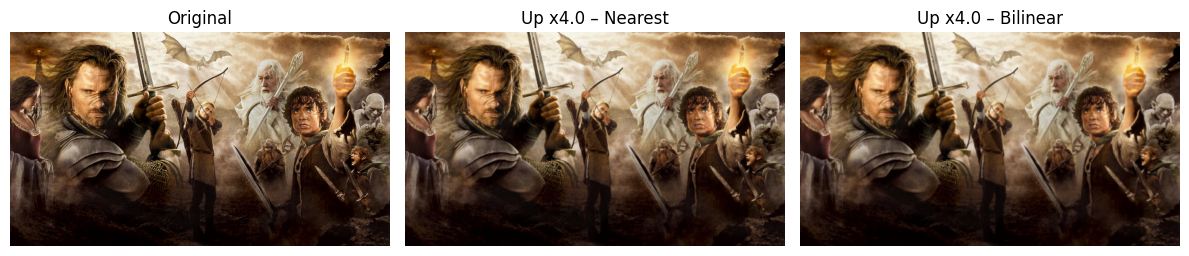

im02small.png        → im02.png   | nSSD nearest = 0.002098, bilinear = 0.001461


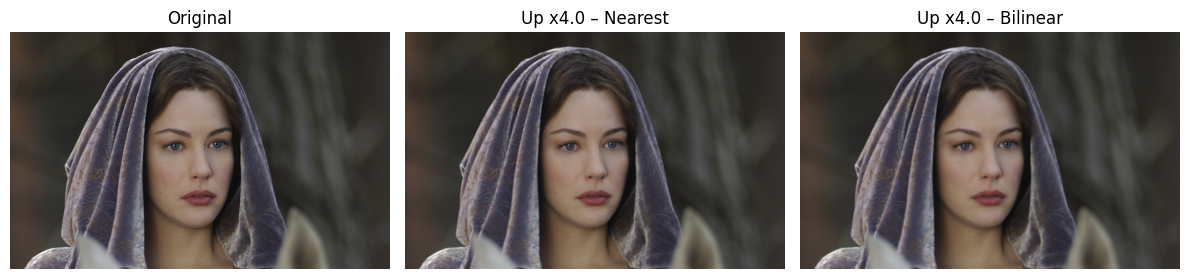

im03small.png        → im03.png   | nSSD nearest = 0.003779, bilinear = 0.002814


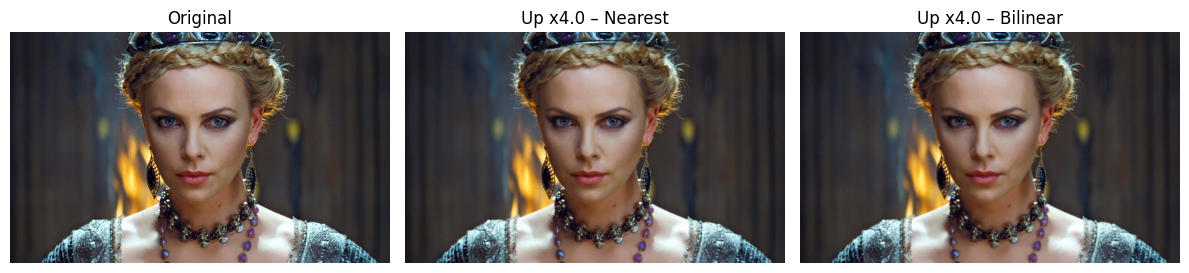

taylor_small.jpg     → taylor.jpg | nSSD nearest = 0.002842, bilinear = 0.002707


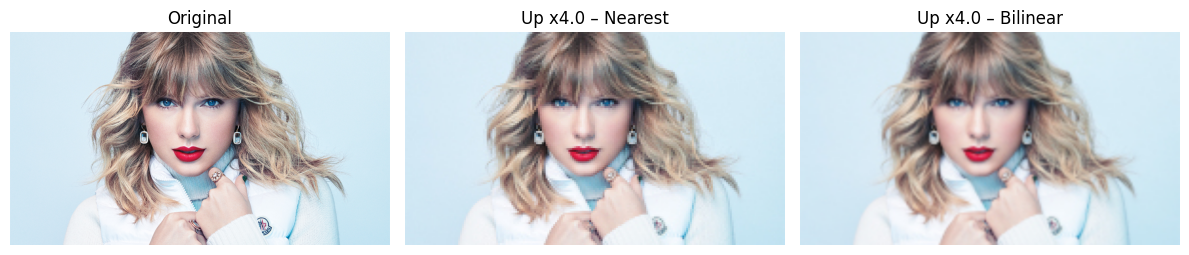

taylor_very_small.jpg → taylor.jpg | nSSD nearest = 0.005697, bilinear = 0.005350


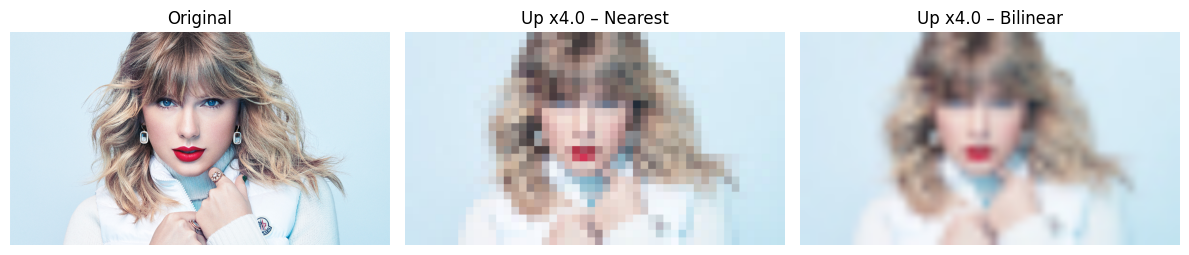

In [ ]:
# Q7 — Image zoom by factor s ∈ (0, 10) with nearest and bilinear + nSSD evaluation
from pathlib import Path
import numpy as np
import cv2
import matplotlib.pyplot as plt

# ---------- paths ----------
DATA_DIR = Path("/content/drive/MyDrive/a1images/a1images")
SUB      = DATA_DIR / "a1q8images"   # folder that contains the images shown in the prompt

# Provide all the pairs you have; missing ones will be skipped gracefully
pairs = [
    ("im01small.png", "im01.png"),
    ("im02small.png", "im02.png"),
    ("im03small.png", "im03.png"),
    ("taylor_small.jpg", "taylor.jpg"),
    ("taylor_very_small.jpg", "taylor.jpg"),
]

# ---------- helpers ----------
def imread_any(p):
    p = str(p)
    img = cv2.imread(p, cv2.IMREAD_UNCHANGED)
    if img is None:
        raise FileNotFoundError(p)
    # Convert BGR→RGB for consistent plotting; keep alpha if present
    if img.ndim == 3 and img.shape[2] == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    elif img.ndim == 3 and img.shape[2] == 4:
        img[:, :, :3] = cv2.cvtColor(img[:, :, :3], cv2.COLOR_BGR2RGB)
    return img

def to_gray(img):
    if img.ndim == 2:
        return img
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def normalized_ssd(a, b):
    a = a.astype(np.float32); b = b.astype(np.float32)
    if a.shape != b.shape:
        raise ValueError(f"nSSD expects same shapes, got {a.shape} vs {b.shape}")
    ssd = np.sum((a - b)**2)
    denom = np.sum(a**2) + np.sum(b**2) + 1e-9
    return float(ssd / denom)

# ---------- core: our own zoom (nearest / bilinear) ----------
def zoom(img, s, method="nearest"):
    """
    Scale an image by factor s (0 < s < 10) using either 'nearest' or 'bilinear'.
    Works for grayscale (H,W) and color (H,W,C).
    """
    if s <= 0 or s >= 10:
        raise ValueError("s must be in (0,10)")

    H, W = img.shape[:2]
    C = 1 if img.ndim == 2 else img.shape[2]

    outH, outW = int(round(H * s)), int(round(W * s))
    # target grid (0..outH-1, 0..outW-1)
    yy, xx = np.meshgrid(np.arange(outH), np.arange(outW), indexing="ij")

    # map target pixel centers back to source coords (half-pixel alignment)
    sy = (yy + 0.5) / s - 0.5
    sx = (xx + 0.5) / s - 0.5

    # clamp to valid range
    sy = np.clip(sy, 0, H - 1)
    sx = np.clip(sx, 0, W - 1)

    if method == "nearest":
        ny = np.rint(sy).astype(np.int32)
        nx = np.rint(sx).astype(np.int32)
        if C == 1:
            out = img[ny, nx]
        else:
            out = img[ny, nx, :]
        return out

    elif method == "bilinear":
        # floor / ceil and weights
        y0 = np.floor(sy).astype(np.int32)
        x0 = np.floor(sx).astype(np.int32)
        y1 = np.clip(y0 + 1, 0, H - 1)
        x1 = np.clip(x0 + 1, 0, W - 1)

        wy = sy - y0
        wx = sx - x0
        w00 = (1 - wy) * (1 - wx)
        w01 = (1 - wy) * wx
        w10 = wy * (1 - wx)
        w11 = wy * wx

        if C == 1:
            Ia = img[y0, x0].astype(np.float32)
            Ib = img[y0, x1].astype(np.float32)
            Ic = img[y1, x0].astype(np.float32)
            Id = img[y1, x1].astype(np.float32)
            out = Ia * w00 + Ib * w01 + Ic * w10 + Id * w11
            return np.clip(out, 0, 255).astype(img.dtype)
        else:
            Ia = img[y0, x0, :].astype(np.float32)
            Ib = img[y0, x1, :].astype(np.float32)
            Ic = img[y1, x0, :].astype(np.float32)
            Id = img[y1, x1, :].astype(np.float32)
            out = (Ia * w00[..., None] + Ib * w01[..., None] +
                   Ic * w10[..., None] + Id * w11[..., None])
            return np.clip(out, 0, 255).astype(img.dtype)

    else:
        raise ValueError("method must be 'nearest' or 'bilinear'")

# ---------- evaluate with nSSD for s=4 ----------
s = 4.0
for small_name, orig_name in pairs:
    sp = SUB / small_name
    op = SUB / orig_name
    if not sp.exists() or not op.exists():
        print(f"Skipping (missing): {small_name} / {orig_name}")
        continue

    small = imread_any(sp)
    orig  = imread_any(op)

    upN = zoom(small, s=s, method="nearest")
    upB = zoom(small, s=s, method="bilinear")

    # If due to rounding out size differs, crop/pad to original size
    H, W = orig.shape[:2]
    upN = cv2.resize(upN, (W, H), interpolation=cv2.INTER_NEAREST)
    upB = cv2.resize(upB, (W, H), interpolation=cv2.INTER_LINEAR)

    # normalized SSD on grayscale
    nssd_nearest  = normalized_ssd(to_gray(upN), to_gray(orig))
    nssd_bilinear = normalized_ssd(to_gray(upB), to_gray(orig))

    print(f"{small_name:20s} → {orig_name:10s} | "
          f"nSSD nearest = {nssd_nearest:.6f}, bilinear = {nssd_bilinear:.6f}")

    # optional: visualize one pair
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.imshow(orig);  plt.title("Original");             plt.axis("off")
    plt.subplot(1,3,2); plt.imshow(upN);   plt.title(f"Up x{s} – Nearest");   plt.axis("off")
    plt.subplot(1,3,3); plt.imshow(upB);   plt.title(f"Up x{s} – Bilinear");  plt.axis("off")
    plt.tight_layout(); plt.show()



## Q8 — GrabCut + background blur on **daisy.jpg**


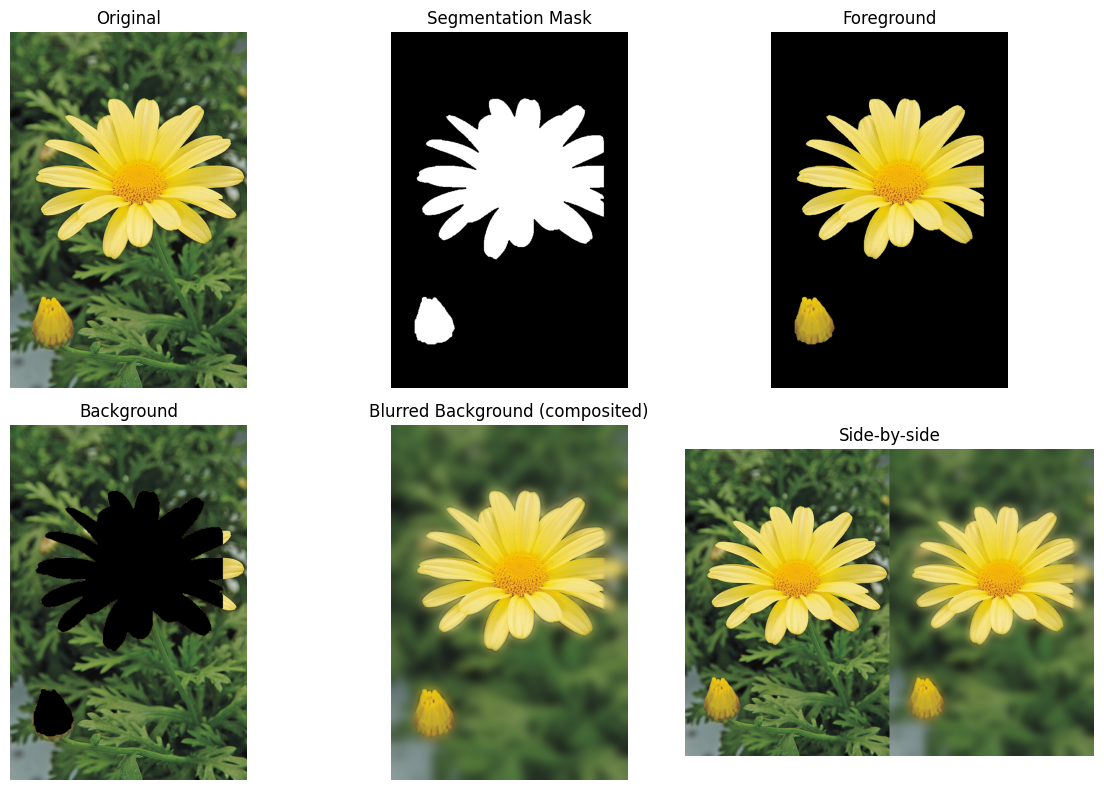

Done. You can adjust rect_margin, blur_sigma, and the feathering sigma to taste.


In [ ]:
# Q8 — GrabCut segmentation + background blur with clean compositing
from pathlib import Path
import numpy as np
import cv2
import matplotlib.pyplot as plt

# -----------------------------
# (a) Load and segment with GrabCut
# -----------------------------
DATA_DIR = Path("/content/drive/MyDrive/a1images/a1images")
q8_path  = DATA_DIR / "daisy.jpg"               # <- given image
bgr = cv2.imread(str(q8_path), cv2.IMREAD_COLOR)
if bgr is None:
    raise FileNotFoundError(q8_path)
rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
h, w = rgb.shape[:2]

# Initialize rectangle (keep margins so the flower falls inside)
rect_margin = 0.10
rect = (
    int(w * rect_margin),
    int(h * rect_margin),
    int(w * (1 - 2*rect_margin)),
    int(h * (1 - 2*rect_margin)),
)

# GrabCut
mask = np.zeros((h, w), np.uint8)
bgdModel = np.zeros((1, 65), np.float64)
fgdModel = np.zeros((1, 65), np.float64)
cv2.grabCut(bgr, mask, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)

# Hard (binary) mask of foreground
hard = np.where((mask == cv2.GC_FGD) | (mask == cv2.GC_PR_FGD), 1, 0).astype(np.uint8)

# Optional clean-up (remove tiny specks / fill tiny gaps)
kernel = np.ones((3,3), np.uint8)
hard = cv2.morphologyEx(hard, cv2.MORPH_OPEN, kernel, iterations=1)
hard = cv2.morphologyEx(hard, cv2.MORPH_CLOSE, kernel, iterations=1)

# Foreground/background images for display
fg = (rgb * hard[..., None]).astype(np.uint8)
bg = (rgb * (1 - hard[..., None])).astype(np.uint8)

# -----------------------------
# (b) Enhanced image with substantially blurred background
#     -> blur the WHOLE image, then blend with a SOFT alpha to avoid halos
# -----------------------------
# Strong background blur
blur_sigma = 12.0
blurred_full = cv2.GaussianBlur(rgb, (0, 0), sigmaX=blur_sigma, sigmaY=blur_sigma)

# Feather the binary mask to a soft alpha
soft = cv2.GaussianBlur((hard*255).astype(np.uint8), (0, 0), sigmaX=3, sigmaY=3)
alpha = (soft.astype(np.float32) / 255.0)[..., None]  # shape (h,w,1)

# Composite: alpha*sharp + (1-alpha)*blurred
enhanced = np.clip(alpha * rgb + (1 - alpha) * blurred_full, 0, 255).astype(np.uint8)

# -----------------------------
# Display (required outputs)
# -----------------------------
plt.figure(figsize=(12,8))
plt.subplot(2,3,1); plt.title("Original");    plt.imshow(rgb); plt.axis("off")
plt.subplot(2,3,2); plt.title("Segmentation Mask"); plt.imshow(hard*255, cmap="gray"); plt.axis("off")
plt.subplot(2,3,3); plt.title("Foreground");  plt.imshow(fg);  plt.axis("off")
plt.subplot(2,3,4); plt.title("Background");  plt.imshow(bg);  plt.axis("off")
plt.subplot(2,3,5); plt.title("Blurred Background (composited)"); plt.imshow(enhanced); plt.axis("off")
plt.subplot(2,3,6); plt.title("Side-by-side");
plt.imshow(np.hstack([rgb, enhanced])); plt.axis("off")
plt.tight_layout(); plt.show()

print("Done. You can adjust rect_margin, blur_sigma, and the feathering sigma to taste.")



## Q9 — Object counting (using **rice.png** as the sample image)

Pipeline: denoise → Otsu → morphology → connected components.


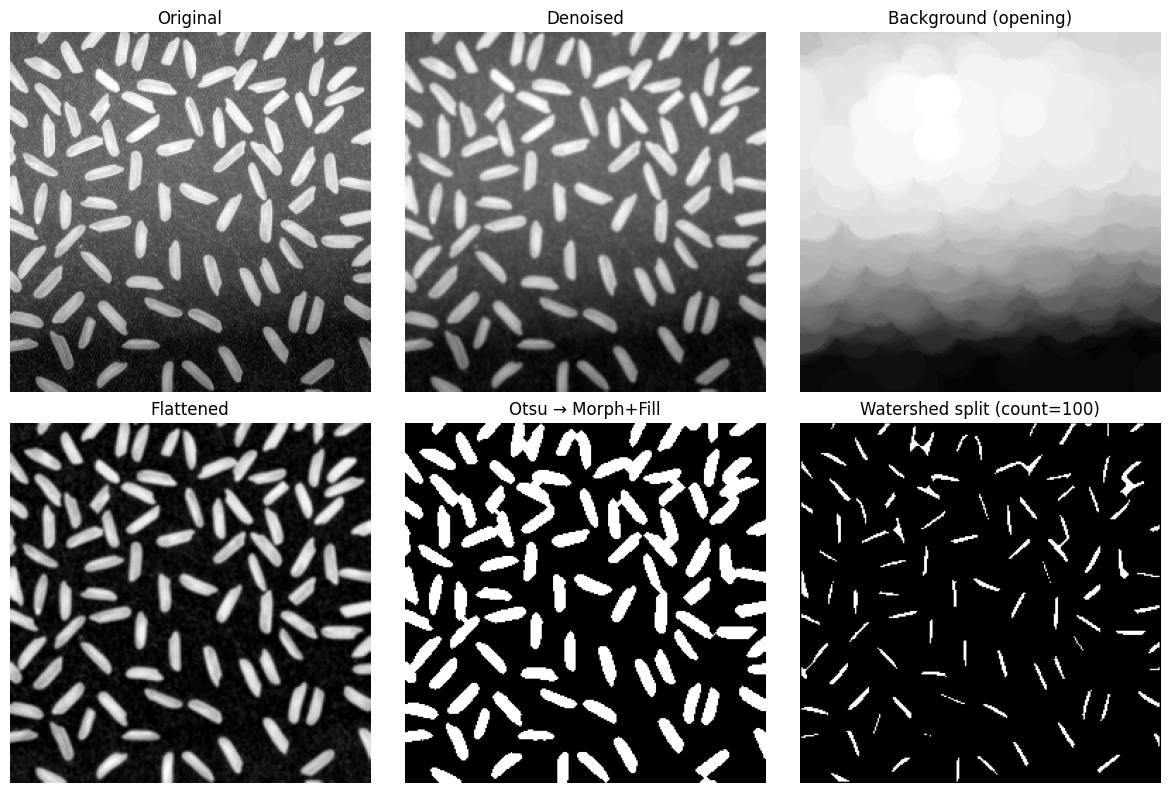

Estimated number of rice grains: 100


In [ ]:
# Q9 — Rice grain counting on rice.png
from pathlib import Path
import cv2, numpy as np, matplotlib.pyplot as plt

# ------------- (a) load & light denoise -------------
DATA_DIR = Path("/content/drive/MyDrive/a1images/a1images")
img_path = DATA_DIR / "rice.png"      # <— your given image
g = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
if g is None:
    raise FileNotFoundError(img_path)

# light Gaussian denoise (rice.png mostly gaussian-like)
g_d = cv2.GaussianBlur(g, (3,3), 0.8)

# ------------- (b) background flattening (key for rice) -------------
# estimate background with large morphological opening and subtract
# disk-ish kernel; adjust size (must be >> grain width)
k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (31,31))
bg = cv2.morphologyEx(g_d, cv2.MORPH_OPEN, k)
flat = cv2.subtract(g_d, bg)                # removes illumination gradient
flat = cv2.normalize(flat, None, 0, 255, cv2.NORM_MINMAX)

# ------------- (c) Otsu threshold; ensure grains are white -------------
_, th_raw = cv2.threshold(flat, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
if np.mean(flat[th_raw>0]) < np.mean(flat[th_raw==0]):
    th_raw = cv2.bitwise_not(th_raw)

# ------------- (d) morphology: clean small noise & fill holes -------------
# small open/close for specks & small gaps
se = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
mask = cv2.morphologyEx(th_raw, cv2.MORPH_OPEN, se, iterations=1)
mask = cv2.morphologyEx(mask,  cv2.MORPH_CLOSE, se, iterations=2)

# remove tiny junk by area (area opening)
num, lab = cv2.connectedComponents(mask)
areas = np.bincount(lab.ravel())
keep = np.ones(num, np.uint8); keep[0] = 0
minA, maxA = 30, 10_000      # tweak if your scale differs
for i,a in enumerate(areas):
    if i==0: continue
    if a<minA or a>maxA: keep[i]=0
mask = (keep[lab]*255).astype(np.uint8)

# fill holes inside grains
def fill_holes(bin255):
    inv = cv2.bitwise_not(bin255)
    h,w = inv.shape
    ffmask = np.zeros((h+2,w+2), np.uint8)
    flood = inv.copy()
    cv2.floodFill(flood, ffmask, (0,0), 255)
    holes = cv2.bitwise_not(flood)
    return cv2.bitwise_or(bin255, holes)

mask_filled = fill_holes(mask)

# ------------- (optional) watershed split of touching grains -------------
bin8 = (mask_filled>0).astype(np.uint8)
dist = cv2.distanceTransform(bin8, cv2.DIST_L2, 5)
markers = (dist > 0.45*dist.max()).astype(np.uint8)      # peak seeds
_, markers = cv2.connectedComponents(markers)
markers = markers + 1
markers[bin8==0] = 0

rgb_for_ws = cv2.cvtColor(g, cv2.COLOR_GRAY2RGB)
ws = cv2.watershed(rgb_for_ws.copy(), markers.astype(np.int32))
seg = (ws > 1).astype(np.uint8) * 255

# ------------- (e) count with connected components -------------
n_final, lab_final = cv2.connectedComponents((seg>0).astype(np.uint8))
count = n_final - 1

# ------------- display -------------
plt.figure(figsize=(12,8))
plt.subplot(2,3,1); plt.title("Original");              plt.imshow(g, cmap="gray"); plt.axis("off")
plt.subplot(2,3,2); plt.title("Denoised");              plt.imshow(g_d, cmap="gray"); plt.axis("off")
plt.subplot(2,3,3); plt.title("Background (opening)");  plt.imshow(bg, cmap="gray"); plt.axis("off")
plt.subplot(2,3,4); plt.title("Flattened");             plt.imshow(flat, cmap="gray"); plt.axis("off")
plt.subplot(2,3,5); plt.title("Otsu → Morph+Fill");     plt.imshow(mask_filled, cmap="gray"); plt.axis("off")
plt.subplot(2,3,6); plt.title(f"Watershed split (count={count})"); plt.imshow(seg, cmap="gray"); plt.axis("off")
plt.tight_layout(); plt.show()

print(f"Estimated number of rice grains: {count}")




## Q10 — Area estimation in mm² (using **sapphire.jpg** as target)



Scale: 0.288000 mm/px  →  0.082944 mm²/px  (pixel_pitch=0.0048 mm)
Areas (pixels): [30197, 34457]
Areas (mm²):    [2504.66, 2858.001]


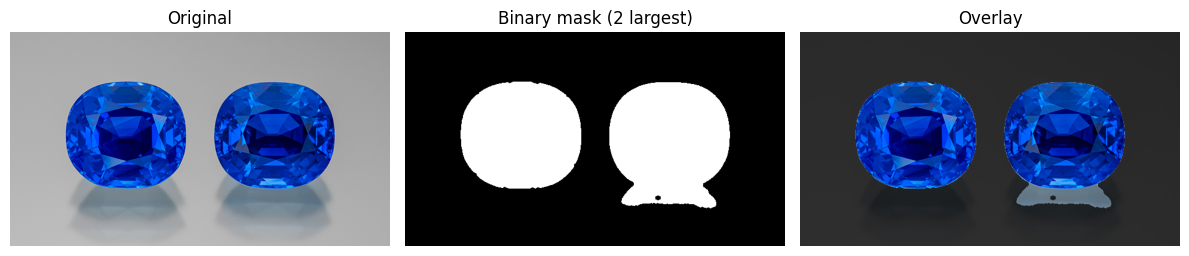

In [ ]:
# Q10 — Two sapphires on a table: segment → fill → pixel areas → mm² areas
from pathlib import Path
import cv2, numpy as np, matplotlib.pyplot as plt

# -----------------------------
# (a) Load and segment sapphires (color-based in HSV)
# -----------------------------
DATA_DIR = Path("/content/drive/MyDrive/a1images/a1images")
img_path = DATA_DIR / "sapphire.jpg"     # <- use the provided image

bgr = cv2.imread(str(img_path), cv2.IMREAD_COLOR)
if bgr is None:
    raise FileNotFoundError(img_path)
rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

# Convert to HSV; sapphires are saturated blue on a gray table
hsv = cv2.cvtColor(bgr, cv2.COLOR_BGR2HSV)

# OpenCV hue in [0,179]; blue roughly ~100–140 (tweak if needed).
# Require decent saturation/value to avoid gray table.
lower = np.array([100, 60, 40], dtype=np.uint8)
upper = np.array([140, 255, 255], dtype=np.uint8)
mask = cv2.inRange(hsv, lower, upper)

# Small cleanups (remove specks / fill small gaps)
se = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN,  se, iterations=1)
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, se, iterations=2)

# -----------------------------
# (b) Fill holes to make each sapphire a solid blob
# -----------------------------
def fill_holes(bin255):
    inv = cv2.bitwise_not(bin255)
    h, w = inv.shape
    ffmask = np.zeros((h+2, w+2), np.uint8)
    flood = inv.copy()
    cv2.floodFill(flood, ffmask, (0,0), 255)
    holes = cv2.bitwise_not(flood)
    return cv2.bitwise_or(bin255, holes)

filled = fill_holes(mask)

# Keep ONLY the two largest components
num, lab, stats, _ = cv2.connectedComponentsWithStats(filled, connectivity=8)
areas = [(i, stats[i, cv2.CC_STAT_AREA]) for i in range(1, num)]
areas_sorted = sorted(areas, key=lambda t: t[1], reverse=True)[:2]
keep = {i for i,_ in areas_sorted}
mask_two = np.where(np.isin(lab, list(keep)), 255, 0).astype(np.uint8)

# Safety: fill holes again after selection
mask_two = fill_holes(mask_two)

# -----------------------------
# (c) Areas in pixels via connectedComponentsWithStats
# -----------------------------
num2, lab2, stats2, cents2 = cv2.connectedComponentsWithStats(mask_two, connectivity=8)
areas_px = [int(stats2[i, cv2.CC_STAT_AREA]) for i in range(1, num2)]

# -----------------------------
# (d) Convert pixel areas → mm² using pinhole model
#     X = (Z/f) * y, with y = pixels * pixel_pitch
# -----------------------------
f_mm = 8.0        # focal length (given)
Z_mm = 480.0      # camera-to-table distance (given)

# >>> Set this to the actual sensor pixel pitch of the camera used.
# 4.8 µm (0.0048 mm) is a reasonable default if unknown.
pixel_pitch_mm = 0.0048

mm_per_px  = (Z_mm / f_mm) * pixel_pitch_mm
mm2_per_px = mm_per_px ** 2
areas_mm2  = [round(a * mm2_per_px, 3) for a in areas_px]

print(f"Scale: {mm_per_px:.6f} mm/px  →  {mm2_per_px:.6f} mm²/px  (pixel_pitch={pixel_pitch_mm} mm)")
print("Areas (pixels):", areas_px)
print("Areas (mm²):   ", areas_mm2)

# -----------------------------
# Visualize outputs
# -----------------------------
overlay = rgb.copy()
overlay[mask_two == 0] = (overlay[mask_two == 0] * 0.25).astype(np.uint8)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.title("Original");        plt.imshow(rgb);          plt.axis("off")
plt.subplot(1,3,2); plt.title("Binary mask (2 largest)"); plt.imshow(mask_two, cmap="gray"); plt.axis("off")
plt.subplot(1,3,3); plt.title("Overlay");         plt.imshow(overlay);      plt.axis("off")
plt.tight_layout(); plt.show()

